In [1]:
import numpy as np
import tflite_runtime.interpreter as tflite
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from pycoral.utils.dataset import read_label_file
from pycoral.adapters.common import input_size
from pycoral.adapters.classify import get_classes

import time

MODEL_DIR = './all_models/image_classifier'
MODEL = 'mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite'
LABELS = 'inat_bird_labels.txt'
IMAGE = "parrot.jpg"

args = {
    "model": os.path.join(MODEL_DIR, MODEL),
    "labels": os.path.join(MODEL_DIR, LABELS),
    "threshold": 0.1,
    "image": os.path.join(MODEL_DIR, IMAGE),
    "top_k": 3,
    "count": 20
}

ModuleNotFoundError: No module named 'tflite_runtime'

In [2]:
tflite.platform.platform()

'Windows-10-10.0.19041-SP0'

In [3]:
args

{'model': './all_models/image_classifier\\mobilenet_v2_1.0_224_inat_bird_quant_edgetpu.tflite',
 'labels': './all_models/image_classifier\\inat_bird_labels.txt',
 'threshold': 0.1,
 'image': './all_models/image_classifier\\parrot.jpg',
 'top_k': 3,
 'count': 20}

In [4]:
delegates = [tflite.load_delegate("edgetpu.dll")]

In [5]:
interpreter = tflite.Interpreter(args["model"], experimental_delegates=delegates)
interpreter.allocate_tensors()
labels = read_label_file(args["labels"])

In [6]:
print(len(labels))
print(labels[100])
print(labels[200])

965
Euphonia elegantissima (Elegant Euphonia)
Coccyzus minor (Mangrove Cuckoo)


(929, 512, 3)


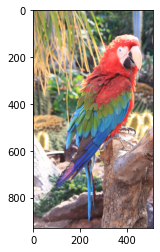

In [7]:
img = cv2.imread(args["image"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.show()

In [8]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [9]:
input_details

[{'name': 'map/TensorArrayStack/TensorArrayGatherV3',
  'index': 0,
  'shape': array([  1, 224, 224,   3]),
  'shape_signature': array([  1, 224, 224,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
output_details

[{'name': 'prediction',
  'index': 1,
  'shape': array([  1, 965]),
  'shape_signature': array([  1, 965]),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [11]:
input_shape = input_details[0]['shape']
input_shape

array([  1, 224, 224,   3])

(224, 224, 3)


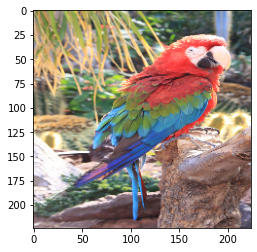

In [12]:
img_resized = cv2.resize(img, input_shape[1:3], cv2.INTER_AREA)
print(img_resized.shape)
plt.imshow(img_resized)
plt.show()

In [13]:
interpreter.set_tensor(input_details[0]['index'], np.array([img_resized]))

In [14]:
interpreter.invoke()

In [15]:
y_scores = interpreter.get_tensor(output_details[0]['index']).flatten()
y_scores

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [16]:
result_args = np.argpartition(y_scores, -args["top_k"])[-args["top_k"]:]
print((np.partition(y_scores, -args["top_k"])[-args["top_k"]:] / 255)[::-1])
results = [labels[i] for i in result_args][::-1]
print(results)

[0.69411765 0.10588235 0.02352941]
['Ara macao (Scarlet Macaw)', 'Platycercus elegans (Crimson Rosella)', 'Coracias caudatus (Lilac-breasted Roller)']


In [17]:
print('----INFERENCE TIME----')
for _ in range(args["count"]):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    classes = get_classes(interpreter, args["top_k"])
    print('%.1fms' % (inference_time * 1000))

print('-------RESULTS--------')
for c in classes:
    print('%s: %.5f' % (labels.get(c.id, c.id), c.score))

----INFERENCE TIME----
4.2ms
4.0ms
4.0ms
3.9ms
3.9ms
4.0ms
4.0ms
4.0ms
4.2ms
4.0ms
4.1ms
4.2ms
4.2ms
4.1ms
3.9ms
4.2ms
4.1ms
4.6ms
4.2ms
4.1ms
-------RESULTS--------
Ara macao (Scarlet Macaw): 0.69141
Platycercus elegans (Crimson Rosella): 0.10547
Coracias caudatus (Lilac-breasted Roller): 0.02344


In [18]:
a = [1,2,34,2,5,76]
a[4::-1] 

[5, 2, 34, 2, 1]